## Train LSTM model 

In [2]:
# Import required modules
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'; 
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn import metrics as skmetrics
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Project folder
BASE_DIR = os.getcwd()
# Data folder
DATA_DIR = os.path.join(BASE_DIR, "data")
# Model folder
MODEL_DIR = os.path.join(BASE_DIR, "model")

In [4]:
# Load data
#df = pd.read_csv(os.path.join(DATA_DIR, "data_entire_eachSub.csv"), header=None)

# Loading training and testing data separately.
# `data_train_eachSub.csv` should contain 80% of the dataset to be used for training.
# `data_test_eachSub.csv` should contain 20% of the dataset to be used for testing.
df_train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"), header=None)
df_test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"), header=None)
#df = pd.read_csv('data_train.csv', header=None)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.435999,9.333276,3.163077,0.008412,0.013030,-0.051731,3.286649,1.903171,10.072385,0.124278,...,0.067008,0.033603,-0.014731,5.308202,1.457947,8.473954,0.049354,0.128589,-0.004342,0
1,0.379209,8.292008,5.896656,1.239547,-0.236625,-0.395311,0.342760,-1.102890,8.863504,-0.249933,...,0.053695,0.005795,-0.028839,2.000651,-0.565427,9.668964,-0.300383,-0.732630,-1.673002,3
2,6.044558,5.488837,6.982038,0.623866,-0.778712,-1.864887,2.252187,-1.409794,8.252557,0.416348,...,-0.044456,-0.112226,-0.045160,3.997835,-3.583484,7.321064,0.058297,-0.629923,0.663067,1
3,2.974789,7.339714,6.368166,-0.676137,-0.632592,1.544789,8.246719,-1.704129,1.357354,-1.033536,...,0.090747,0.086601,0.027731,9.959971,-0.419618,3.842174,-1.364561,-0.253874,-0.480970,2
4,2.009309,3.444532,7.799185,0.439760,-0.364595,-1.271761,0.624367,1.550282,8.894447,-0.731978,...,0.180536,-0.000958,-0.027007,4.540139,-0.722846,7.219041,-0.382768,-0.063792,1.235754,1


In [5]:
'''
    *** Fixed parameters that are defined and should not be changed
'''
NUM_XSENS = 4
INPUT_FEATURES = NUM_XSENS * 6

In [6]:
'''
    *** Parameters that should be tuned to solve the challenge ***
'''

# Number of tasks to classify (according to your experimental acquisition protocol)
N_CLASSES = 4 
# Length of the time window
WINDOW_LENGTH = 5
# Stride length (i.e., overlap between adjacent windows)
STRIDE_LENGTH = 1

# Learning rate
learning_rate = 1e-3
# Number of neurons for each LSTM layer
neurons = [40, 20]
# Dropout ratio for each LSTM layer 
dropouts = [0.15, 0.15]
# Number of training epochs
N_EPOCHS = 5
# Batch size for training
batch_size = 32

# Please provide a dropout value for each LSTM layer
# Set dropout[i] = 0.0 to keep all connections
assert(len(neurons) == len(dropouts))

In [7]:
# Data preparation
#X = df.iloc[:,0:-1].to_numpy()
#y = df.iloc[:,-1].to_numpy()
#y = tf.keras.utils.to_categorical(y)

# Apply pre-processing to both training and testing data

X_train = df_train.iloc[:,0:-1].to_numpy()
y_train = df_train.iloc[:,-1].to_numpy()
y_train = tf.keras.utils.to_categorical(y_train)

X_test = df_test.iloc[:,0:-1].to_numpy()
y_test = df_test.iloc[:,-1].to_numpy()
y_test = tf.keras.utils.to_categorical(y_test)

#print("Input shape (X): {} --- Output shape (y): {}".format(X.shape, y.shape))

print("TRAIN Input shape (X): {} --- Output shape (y): {}".format(X_train.shape, y_train.shape))
print("TEST  Input shape (X): {} --- Output shape (y): {}".format(X_test.shape, y_test.shape))

TRAIN Input shape (X): (67490, 24) --- Output shape (y): (67490, 4)
TEST  Input shape (X): (16873, 24) --- Output shape (y): (16873, 4)


In [8]:
def build_sequences(df, y, window_length, input_features, stride):
    # Sanity check to avoid runtime errors
    assert window_length % stride == 0
    dataset = []; labels = []
    # Take only meaningful features
    if type(df) == pd.core.frame.DataFrame:
        temp = df.copy().values
    else:
        temp = df
    # Compute padding length
    padding_len = window_length - len(temp)%window_length
    # Create padding and concatenate it
    padding = np.zeros((padding_len, input_features), dtype='float64')
    temp = np.concatenate((temp,padding))
    # Build features windows with their corresponding labels
    idx = 0
    while idx+window_length < len(temp):
        dataset.append(temp[idx:idx+window_length])
        labels.append(y[idx])
        idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [9]:
'''
    NOTE: in this example, we open a single file and we apply the train_test_split function
          to extract 80% for training and 20% for testing the model.
          In your code, you will need to load 2 files, 1 for training and 1 for testing
'''

# No need to use `train_test_split` function as the data was already loaded into two separate variables.

# Use stratify=y to stratify on y (target variable)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train sets shape: {} {}".format(X_train.shape, y_train.shape))
print("Train sets shape: {} {}".format(X_test.shape, y_test.shape))


Train sets shape: (67490, 24) (67490, 4)
Train sets shape: (16873, 24) (16873, 4)


In [10]:
# Fit and trasnform with scaler
scaler = sklearn.preprocessing.MinMaxScaler((-1,1))
scaler.fit(X_train)

# Scale input (X) data 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Convert to sequences of length WINDOW_LENGTH
X_train, y_train = build_sequences(X_train, y_train, window_length=WINDOW_LENGTH, input_features=INPUT_FEATURES, stride=STRIDE_LENGTH)
X_test, y_test = build_sequences(X_test, y_test, window_length=WINDOW_LENGTH, input_features=INPUT_FEATURES, stride=STRIDE_LENGTH)

print("Train sets shape: {} {}".format(X_train.shape, y_train.shape))
print("Train sets shape: {} {}".format(X_test.shape, y_test.shape))

Train sets shape: (67490, 5, 24) (67490, 4)
Train sets shape: (16870, 5, 24) (16870, 4)


In [12]:
# LSTM model 
def lstm_model(neurons=neurons, dropouts=dropouts, learning_rate=learning_rate, output_classes=N_CLASSES, window=WINDOW_LENGTH, features=INPUT_FEATURES):
    # Input layer
    input_layer = tf.keras.layers.Input((window, features))
    x = input_layer
    # Build the model recursively based on the list of neurons for each LSTM cell
    # Add a dropout layer after every LSTM layer
    for i in range(len(neurons)):
        y = tf.keras.layers.LSTM(neurons[i], activation = "tanh", return_sequences = not(i == len(neurons)-1), kernel_initializer = "HeUniform")(x)
        y = tf.keras.layers.Dropout(dropouts[i])(y)
        x = y
    # Output layer with N_CLASSES neurons: each provides the probability that the input belongs to that class (their sum equals 1)
    output_layer = tf.keras.layers.Dense(output_classes, activation='softmax', kernel_initializer="RandomNormal", name='output_layer')(x)
    # Build the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='task-classifier')
    # Optimizer
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    # Compile and return the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [13]:
# Create the LSTM model and print its structure
model = lstm_model()
model.summary()

Model: "task-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 24)]           0         
                                                                 
 lstm (LSTM)                 (None, 5, 40)             10400     
                                                                 
 dropout (Dropout)           (None, 5, 40)             0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                4880      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 output_layer (Dense)        (None, 4)                 84        
                                                                 
Total params: 15,364
Trainable params: 15,364
Non-t

In [14]:
# Fit with train data (NOTE: early stopping is active)
# Read more here: https://keras.io/api/callbacks/early_stopping/
history = model.fit(X_train.reshape(-1, WINDOW_LENGTH, INPUT_FEATURES), y_train, 
          epochs=N_EPOCHS,
          batch_size=batch_size, 
          validation_data=(X_test.reshape(-1, WINDOW_LENGTH, INPUT_FEATURES), y_test),
          callbacks=EarlyStopping(monitor='val_loss', patience=8, mode='min', restore_best_weights=True))

Epoch 1/5
2110/2110 [==============================] - 40s 16ms/step - loss: 0.5415 - accuracy: 0.7965 - val_loss: 0.3415 - val_accuracy: 0.8838
Epoch 2/5
2110/2110 [==============================] - 31s 15ms/step - loss: 0.3065 - accuracy: 0.8958 - val_loss: 0.2503 - val_accuracy: 0.9136
Epoch 3/5
2110/2110 [==============================] - 30s 14ms/step - loss: 0.2386 - accuracy: 0.9198 - val_loss: 0.2096 - val_accuracy: 0.9260
Epoch 4/5
2110/2110 [==============================] - 32s 15ms/step - loss: 0.2033 - accuracy: 0.9305 - val_loss: 0.2067 - val_accuracy: 0.9233
Epoch 5/5
2110/2110 [==============================] - 33s 16ms/step - loss: 0.1815 - accuracy: 0.9387 - val_loss: 0.1647 - val_accuracy: 0.9427


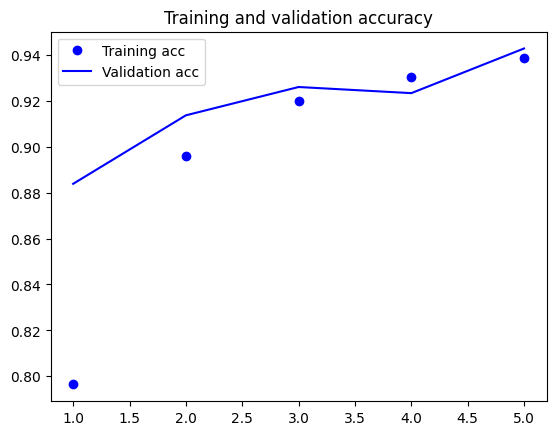

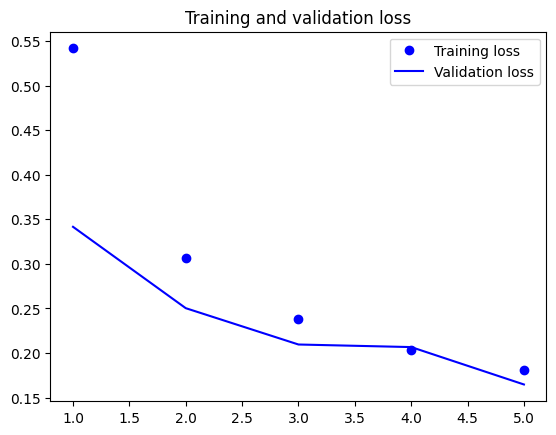

In [15]:
# Plot training history (loss and accuracy)
epochs = range(1, N_EPOCHS+1)

plt.plot(epochs, history.history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [16]:
# Model evaluation
y_pred = model.predict(X_test.reshape(-1, WINDOW_LENGTH, INPUT_FEATURES), 
                       batch_size=1,   # predict with batch_size = 1 for real-time use                
)
y_pred = np.argmax(y_pred, axis=-1) # Convert to Nx1 array
y_test = np.argmax(y_test, axis=-1)

print("Test accuracy: {:4.2f} %".format(100*skmetrics.accuracy_score(y_test, y_pred)))

16870/16870 [==============================] - 61s 4ms/step
Test accuracy: 94.27 %


In [17]:
# Save model for real-time use
try:
    os.makedirs(MODEL_DIR)
except FileExistsError:
    pass
try:
    os.makedirs(MODEL_DIR)
except FileExistsError:
    pass

model.save(os.path.join(MODEL_DIR, "{}.h5".format(model.name)))
with open(os.path.join(MODEL_DIR, "{}_scaler.h5".format(model.name)), 'wb') as f:
    pickle.dump(scaler,f)

print("Model exported to {}".format(MODEL_DIR))

Model exported to c:\Users\Elisa\Desktop\Neuroengeneering\PW-FES-master\tensorflow\model
